## Random Forest - viscosity - 2bins - 50/50

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

In [2]:
df = pd.read_csv(f"../Viscosity_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Chemicals                                    100 non-null    object 
 1   SMILES                                       100 non-null    object 
 2   Temperature (kelvin)                         100 non-null    float64
 3   Dynamic Viscosity (cp)                       100 non-null    float64
 4   Classification (based on dynamic viscosity)  100 non-null    object 
 5   viscosity_2bins_5050                         100 non-null    int64  
 6   viscosity_7228                               100 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 5.6+ KB


In [8]:
def smiles_to_fingerprint(smiles) -> np.ndarray:
    """
    Convert a SMILES string to a molecular fingerprint using RDKit.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # generate Morgan fingerprint
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=20, fpSize=512)
    fingerprint = mfpgen.GetFingerprint(mol)

    return np.array(fingerprint)

In [9]:
df["mp_bin"] = df["SMILES"].apply(smiles_to_fingerprint)
df["mp_bin"]

0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
2     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                            ...                        
95    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
96    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
97    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
98    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
99    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: mp_bin, Length: 100, dtype: object

In [18]:
def prepare_dataset_classification(
    df,
    target = "viscosity_2bins_5050",
    representation = "mp_bin",
    random_state=42,
    train_size=80
):
    df_train, df_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )
    print(len(df_train), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return list(X_train), y_train, list(X_test), y_test

In [19]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, random_state=42):
    clf = RandomForestClassifier(
        n_estimators=200, 
        random_state=random_state,
        verbose=True
    )
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [20]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 40

In [21]:
train_size = 40
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [22]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
40 60
random_state = 42
Accuracy: 0.75
F1 macro: 0.7413049726933026
F1 micro: 0.75
F1 weighted: 0.7413049726933026
Kappa: 0.5
-------------Iteration 2/10
40 60
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7166666666666667
F1 macro: 0.7165879410947485
F1 micro: 0.7166666666666667
F1 weighted: 0.7165879410947485
Kappa: 0.43333333333333335
-------------Iteration 3/10
40 60
random_state = 44
Accuracy: 0.6166666666666667
F1 macro: 0.6033342914630642
F1 micro: 0.6166666666666667
F1 weighted: 0.6033342914630642
Kappa: 0.23333333333333328
-------------Iteration 4/10
40 60
random_state = 45


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7666666666666667
F1 macro: 0.765625
F1 micro: 0.7666666666666667
F1 weighted: 0.765625
Kappa: 0.5333333333333333
-------------Iteration 5/10
40 60
random_state = 46
Accuracy: 0.6833333333333333
F1 macro: 0.6760443307757886
F1 micro: 0.6833333333333333
F1 weighted: 0.6760443307757886
Kappa: 0.3666666666666667
-------------Iteration 6/10
40 60
random_state = 47


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.6666666666666666
F1 macro: 0.6336996336996337
F1 micro: 0.6666666666666666
F1 weighted: 0.6336996336996337
Kappa: 0.33333333333333337
-------------Iteration 7/10
40 60
random_state = 48
Accuracy: 0.75
F1 macro: 0.7482517482517483
F1 micro: 0.75
F1 weighted: 0.7482517482517482
Kappa: 0.5
-------------Iteration 8/10
40 60
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.6666666666666666
F1 macro: 0.6474735605170387
F1 micro: 0.6666666666666666
F1 weighted: 0.6474735605170387
Kappa: 0.33333333333333337
-------------Iteration 9/10
40 60
random_state = 50
Accuracy: 0.7833333333333333
F1 macro: 0.7757976430008624
F1 micro: 0.7833333333333333
F1 weighted: 0.7757976430008623
Kappa: 0.5666666666666667
-------------Iteration 10/10
40 60
random_state = 51
Accuracy: 0.75
F1 macro: 0.7493734335839599
F1 micro: 0.75
F1 weighted: 0.7493734335839598
Kappa: 0.5


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [23]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 40
mean accuracy: 0.7150000000000001 +/- 0.05134307266916455
mean F1 macro: 0.7057492555080147 +/- 0.05791503288779739
mean F1 micro: 0.7150000000000001 +/- 0.05134307266916455
mean F1 weighted: 0.7057492555080147 +/- 0.05791503288779736
mean Kappa: 0.43 +/- 0.1026861453383291


In [24]:
compiled_res_40 = pd.DataFrame(metrics_dict())
compiled_res_40.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",0.750000,0.741305,0.750000,0.741305,0.500000
1,40,"[0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, ...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...",0.716667,0.716588,0.716667,0.716588,0.433333
2,40,"[1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, ...",0.616667,0.603334,0.616667,0.603334,0.233333


### training size = 50

In [25]:
train_size = 50
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [26]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
50 50
random_state = 42
Accuracy: 0.74
F1 macro: 0.7312939231087227
F1 micro: 0.74
F1 weighted: 0.7312939231087227
Kappa: 0.48
-------------Iteration 2/10
50 50
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.7
F1 macro: 0.6998799519807923
F1 micro: 0.7
F1 weighted: 0.6998799519807923
Kappa: 0.4
-------------Iteration 3/10
50 50
random_state = 44
Accuracy: 0.66
F1 macro: 0.6565656565656566
F1 micro: 0.66
F1 weighted: 0.6565656565656566
Kappa: 0.31999999999999995
-------------Iteration 4/10
50 50
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.68
F1 macro: 0.68
F1 micro: 0.68
F1 weighted: 0.68
Kappa: 0.36
-------------Iteration 5/10
50 50
random_state = 46
Accuracy: 0.7
F1 macro: 0.6940024479804161
F1 micro: 0.7
F1 weighted: 0.6940024479804161
Kappa: 0.4
-------------Iteration 6/10
50 50
random_state = 47


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.74
F1 macro: 0.7398959583833533
F1 micro: 0.74
F1 weighted: 0.7398959583833533
Kappa: 0.48
-------------Iteration 7/10
50 50
random_state = 48
Accuracy: 0.74
F1 macro: 0.7312939231087227
F1 micro: 0.74
F1 weighted: 0.7312939231087227
Kappa: 0.48
-------------Iteration 8/10
50 50
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7
F1 macro: 0.696969696969697
F1 micro: 0.7
F1 weighted: 0.6969696969696969
Kappa: 0.4
-------------Iteration 9/10
50 50
random_state = 50
Accuracy: 0.74
F1 macro: 0.7267759562841529
F1 micro: 0.74
F1 weighted: 0.726775956284153
Kappa: 0.48
-------------Iteration 10/10
50 50
random_state = 51
Accuracy: 0.72
F1 macro: 0.719551282051282
F1 micro: 0.72
F1 weighted: 0.719551282051282
Kappa: 0.43999999999999995


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [27]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 50
mean accuracy: 0.712 +/- 0.02712931993250106
mean F1 macro: 0.7076228796432795 +/- 0.025298494489590533
mean F1 micro: 0.712 +/- 0.02712931993250106
mean F1 weighted: 0.7076228796432795 +/- 0.02529849448959055
mean Kappa: 0.42400000000000004 +/- 0.054258639865002144


In [28]:
compiled_res_50 = pd.DataFrame(metrics_dict())
compiled_res_50.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,50,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ...",0.74,0.731294,0.74,0.731294,0.48
1,50,"[0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...",0.70,0.699880,0.70,0.699880,0.40
2,50,"[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, ...",0.66,0.656566,0.66,0.656566,0.32


### training size = 60

In [29]:
train_size = 60
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [30]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
60 40
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.75
F1 macro: 0.7395833333333333
F1 micro: 0.75
F1 weighted: 0.7395833333333333
Kappa: 0.5
-------------Iteration 2/10
60 40
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.825
F1 macro: 0.8222222222222222
F1 micro: 0.825
F1 weighted: 0.8222222222222222
Kappa: 0.65
-------------Iteration 3/10
60 40
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.65
F1 macro: 0.6354166666666667
F1 micro: 0.65
F1 weighted: 0.6354166666666667
Kappa: 0.30000000000000004
-------------Iteration 4/10
60 40
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.775
F1 macro: 0.7737272155876807
F1 micro: 0.775
F1 weighted: 0.7737272155876808
Kappa: 0.55
-------------Iteration 5/10
60 40
random_state = 46
Accuracy: 0.725
F1 macro: 0.7163120567375887
F1 micro: 0.725
F1 weighted: 0.7163120567375886
Kappa: 0.44999999999999996
-------------Iteration 6/10
60 40
random_state = 47


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.775
F1 macro: 0.7630019749835418
F1 micro: 0.775
F1 weighted: 0.7630019749835418
Kappa: 0.55
-------------Iteration 7/10
60 40
random_state = 48
Accuracy: 0.725
F1 macro: 0.7103357472021066
F1 micro: 0.725
F1 weighted: 0.7103357472021067
Kappa: 0.44999999999999996
-------------Iteration 8/10
60 40
random_state = 49


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7
F1 macro: 0.6799999999999999
F1 micro: 0.7
F1 weighted: 0.6799999999999999
Kappa: 0.4
-------------Iteration 9/10
60 40
random_state = 50


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.75
F1 macro: 0.7395833333333333
F1 micro: 0.75
F1 weighted: 0.7395833333333333
Kappa: 0.5
-------------Iteration 10/10
60 40
random_state = 51
Accuracy: 0.725
F1 macro: 0.7206349206349206
F1 micro: 0.725
F1 weighted: 0.7206349206349206
Kappa: 0.44999999999999996


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [31]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 60
mean accuracy: 0.74 +/- 0.045
mean F1 macro: 0.7300817470701394 +/- 0.04878268752539641
mean F1 micro: 0.74 +/- 0.045
mean F1 weighted: 0.7300817470701394 +/- 0.04878268752539642
mean Kappa: 0.48 +/- 0.09


In [32]:
compiled_res_60 = pd.DataFrame(metrics_dict())
compiled_res_60.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,60,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...",0.750,0.739583,0.750,0.739583,0.50
1,60,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...",0.825,0.822222,0.825,0.822222,0.65
2,60,"[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...",0.650,0.635417,0.650,0.635417,0.30


### training size = 70

In [33]:
train_size = 70
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [34]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
70 30
random_state = 42
Accuracy: 0.7666666666666667
F1 macro: 0.76
F1 micro: 0.7666666666666667
F1 weighted: 0.7599999999999999
Kappa: 0.5333333333333333
-------------Iteration 2/10
70 30
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.8666666666666667
F1 macro: 0.8660714285714286
F1 micro: 0.8666666666666667
F1 weighted: 0.8660714285714285
Kappa: 0.7333333333333334
-------------Iteration 3/10
70 30
random_state = 44
Accuracy: 0.7333333333333333
F1 macro: 0.7321428571428572
F1 micro: 0.7333333333333333
F1 weighted: 0.7321428571428572
Kappa: 0.4666666666666667
-------------Iteration 4/10
70 30
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.8
F1 macro: 0.8
F1 micro: 0.8
F1 weighted: 0.8
Kappa: 0.6
-------------Iteration 5/10
70 30
random_state = 46
Accuracy: 0.8333333333333334
F1 macro: 0.8331479421579533
F1 micro: 0.8333333333333334
F1 weighted: 0.8331479421579533
Kappa: 0.6666666666666667
-------------Iteration 6/10
70 30
random_state = 47


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.8333333333333334
F1 macro: 0.8285714285714285
F1 micro: 0.8333333333333334
F1 weighted: 0.8285714285714285
Kappa: 0.6666666666666667
-------------Iteration 7/10
70 30
random_state = 48
Accuracy: 0.8666666666666667
F1 macro: 0.8642533936651584
F1 micro: 0.8666666666666667
F1 weighted: 0.8642533936651584
Kappa: 0.7333333333333334
-------------Iteration 8/10
70 30
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.6666666666666666
F1 macro: 0.6411483253588517
F1 micro: 0.6666666666666666
F1 weighted: 0.6411483253588517
Kappa: 0.33333333333333337
-------------Iteration 9/10
70 30
random_state = 50
Accuracy: 0.8
F1 macro: 0.7991071428571428
F1 micro: 0.8
F1 weighted: 0.7991071428571428
Kappa: 0.6
-------------Iteration 10/10
70 30
random_state = 51
Accuracy: 0.7333333333333333
F1 macro: 0.7222222222222222
F1 micro: 0.7333333333333333
F1 weighted: 0.7222222222222221
Kappa: 0.4666666666666667


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [35]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 70
mean accuracy: 0.79 +/- 0.06155395104206466
mean F1 macro: 0.7846664740547044 +/- 0.06748814782959062
mean F1 micro: 0.79 +/- 0.06155395104206466
mean F1 weighted: 0.7846664740547042 +/- 0.06748814782959062
mean Kappa: 0.58 +/- 0.12310790208412928


In [36]:
compiled_res_70 = pd.DataFrame(metrics_dict())
compiled_res_70.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,70,"[0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...",0.766667,0.760000,0.766667,0.760000,0.533333
1,70,"[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.866667,0.866071,0.866667,0.866071,0.733333
2,70,"[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, ...",0.733333,0.732143,0.733333,0.732143,0.466667


### training size = 80

In [37]:
train_size = 80
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [38]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
80 20
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.75
F1 macro: 0.7442455242966752
F1 micro: 0.75
F1 weighted: 0.7442455242966752
Kappa: 0.5
-------------Iteration 2/10
80 20
random_state = 43
Accuracy: 0.85
F1 macro: 0.8465473145780051
F1 micro: 0.85
F1 weighted: 0.846547314578005
Kappa: 0.7
-------------Iteration 3/10
80 20
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.95
F1 macro: 0.949874686716792
F1 micro: 0.95
F1 weighted: 0.949874686716792
Kappa: 0.9
-------------Iteration 4/10
80 20
random_state = 45
Accuracy: 0.8
F1 macro: 0.797979797979798
F1 micro: 0.8
F1 weighted: 0.7979797979797979
Kappa: 0.6
-------------Iteration 5/10
80 20
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.8
F1 macro: 0.797979797979798
F1 micro: 0.8
F1 weighted: 0.7979797979797979
Kappa: 0.6
-------------Iteration 6/10
80 20
random_state = 47
Accuracy: 0.85
F1 macro: 0.8465473145780051
F1 micro: 0.85
F1 weighted: 0.846547314578005
Kappa: 0.7
-------------Iteration 7/10
80 20
random_state = 48


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Accuracy: 0.8
F1 macro: 0.7916666666666667
F1 micro: 0.8
F1 weighted: 0.7916666666666667
Kappa: 0.6
-------------Iteration 8/10
80 20
random_state = 49
Accuracy: 0.65
F1 macro: 0.6419437340153453
F1 micro: 0.65
F1 weighted: 0.6419437340153452
Kappa: 0.30000000000000004
-------------Iteration 9/10
80 20
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.9
F1 macro: 0.898989898989899
F1 micro: 0.9
F1 weighted: 0.898989898989899
Kappa: 0.8
-------------Iteration 10/10
80 20
random_state = 51
Accuracy: 0.65
F1 macro: 0.6266666666666667
F1 micro: 0.65
F1 weighted: 0.6266666666666666
Kappa: 0.30000000000000004


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [39]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 80
mean accuracy: 0.8 +/- 0.09219544457292886
mean F1 macro: 0.794244140246765 +/- 0.0971986747304734
mean F1 micro: 0.8 +/- 0.09219544457292886
mean F1 weighted: 0.794244140246765 +/- 0.09719867473047342
mean Kappa: 0.6 +/- 0.18439088914585774


In [40]:
compiled_res_80 = pd.DataFrame(metrics_dict())
compiled_res_80.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,80,"[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.75,0.744246,0.75,0.744246,0.5
1,80,"[0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...",0.85,0.846547,0.85,0.846547,0.7
2,80,"[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, ...","[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, ...",0.95,0.949875,0.95,0.949875,0.9


In [41]:
compiled_res = pd.concat([
    compiled_res_40, 
    compiled_res_50,
    compiled_res_60,
    compiled_res_70,
    compiled_res_80,
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

50


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",0.750000,0.741305,0.750000,0.741305,0.500000
1,40,"[0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, ...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...",0.716667,0.716588,0.716667,0.716588,0.433333
2,40,"[1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, ...",0.616667,0.603334,0.616667,0.603334,0.233333
3,40,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, ...",0.766667,0.765625,0.766667,0.765625,0.533333
4,40,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...",0.683333,0.676044,0.683333,0.676044,0.366667


In [42]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [49]:
compiled_res.to_csv("RF_results_viscosity_2bins_5050.csv", sep=",", index=False)

In [50]:
df = pd.read_csv("RF_results_viscosity_2bins_5050.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   50 non-null     int64  
 1   y_true       50 non-null     object 
 2   y_pred       50 non-null     object 
 3   accuracy     50 non-null     float64
 4   f1_macro     50 non-null     float64
 5   f1_micro     50 non-null     float64
 6   f1_weighted  50 non-null     float64
 7   kappa        50 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.2+ KB


In [51]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",0.750000,0.741305,0.750000,0.741305,0.500000
1,40,"[0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, ...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...",0.716667,0.716588,0.716667,0.716588,0.433333
2,40,"[1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, ...",0.616667,0.603334,0.616667,0.603334,0.233333


In [52]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro           f1_micro            \
               mean       sem      mean       sem     mean       sem   
train_size                                                             
40            0.715  0.017114  0.705749  0.019305    0.715  0.017114   
50            0.712  0.009043  0.707623  0.008433    0.712  0.009043   
60            0.740  0.015000  0.730082  0.016261    0.740  0.015000   
70            0.790  0.020518  0.784666  0.022496    0.790  0.020518   
80            0.800  0.030732  0.794244  0.032400    0.800  0.030732   

           f1_weighted            kappa            
                  mean       sem   mean       sem  
train_size                                         
40            0.705749  0.019305  0.430  0.034229  
50            0.707623  0.008433  0.424  0.018086  
60            0.730082  0.016261  0.480  0.030000  
70            0.784666  0.022496  0.580  0.041036  
80            0.794244  0.032400  0.600  0.061464

In [53]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.94 0.06]
 [0.34 0.66]]
accuracy: 0.8


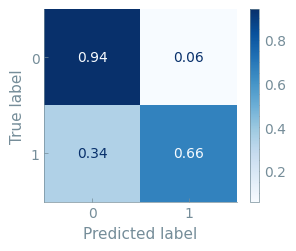

In [54]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_viscosity_confusionMatrix_50_50_size80_RF.pdf', bbox_inches='tight')